# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descargar los datos y haz el remuestreo por una hora.
2. Analizar los datos
3. Entrenar diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.
4. Probar los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

- Importamos las librerias que utilzaremos en el proyecto.


In [1]:
#Librerias estandar
import pandas
import numpy
import matplotlib.pyplot as plt
import datetime
#Librerias de terceros

#Librerias especificas
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

- Leemos los datos y los dejamos en un DataFrame donde la primera columna la convertimos en el index del DataFrame y las convertimos en tipo 'Date'.

In [2]:
df = pandas.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)

- Verificamos si las fechas y horas estan en orden Cronologico.

In [3]:
# comprobar que el índice es monótono
print(df.index.is_monotonic)

True


- Agrupamos los datos por la suma de pedidos de taxi cada hora en los primeros 3 meses del DataSet.

In [4]:
df=df['2018-03':'2018-06'].resample('1H').sum()

- Realizamos un analisis exploratorio inicial del DataSet.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2928 entries, 2018-03-01 00:00:00 to 2018-06-30 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  2928 non-null   int64
dtypes: int64(1)
memory usage: 45.8 KB


In [6]:
df.describe()

,num_orders
count,2928.000000
mean,69.478484
std,33.797497
min,0.000000
25%,47.000000
50%,67.000000
75%,89.000000
max,253.000000


- Podemos observar que tenemos datos duplicados, en este contexto es algo probable ya que estamos obteniendo la suma de pedidos cada hora de cada dia del dataset, como estamos hablando de pedidos de taxi cierto que piden taxi por rutina, viajes programados semanales o diarios, etc. por ende es normal que haya dias que se repitan la cantidad de pedidos por hora

In [7]:
print('Comprobamos los datos duplicados en el dataset.')
print('El dataset tiene',df.duplicated().sum(),'duplicados.')

Comprobamos los datos duplicados en el dataset.
El dataset tiene 2745 duplicados.


In [8]:
print('Comprobamos si hay datos nulos.')
print(df.isnull().sum())

Comprobamos si hay datos nulos.
num_orders    0
dtype: int64


## Análisis

- Realizamos una del DataFrame original para poder trabajar con este con el objetivo obtener la media movil y la desviacion estandar sin afectar los futuros procesos del proyecto, ya que solo usaremos esta copia para poder graficar las estadisticas antes mencionadas.

<AxesSubplot:xlabel='datetime'>

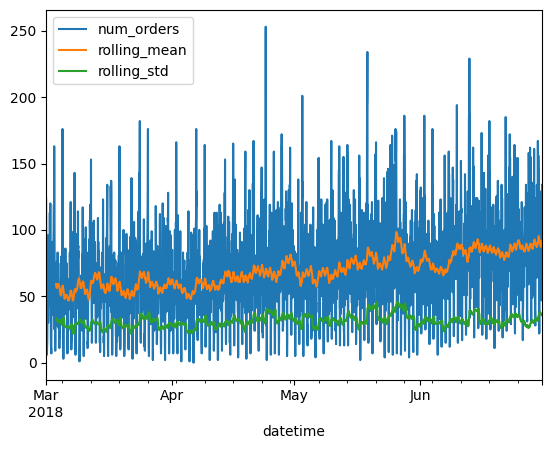

In [9]:
df_rolling=df.copy()
mean_ten = df['num_orders'].rolling(60).mean()
std_ten = df['num_orders'].rolling(60).std()
df_rolling['rolling_mean']=mean_ten
df_rolling['rolling_std']=std_ten
df_rolling.plot()

- Ahora utilizamos el DataFrame original para calcular las tendencia de los datos con la libreria seasonal_descompose

In [10]:
decomposed = seasonal_decompose(df)

- Graficamos distintos dias del DataFrame para visualizar las horas del dia que se obtienen mayor cantidad de pedidos de taxi de una forma sencilla de comparar.

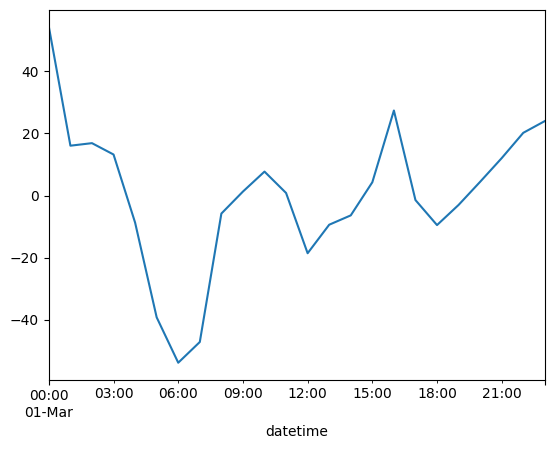

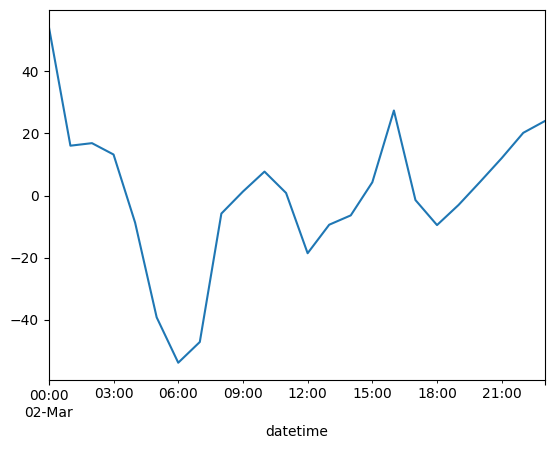

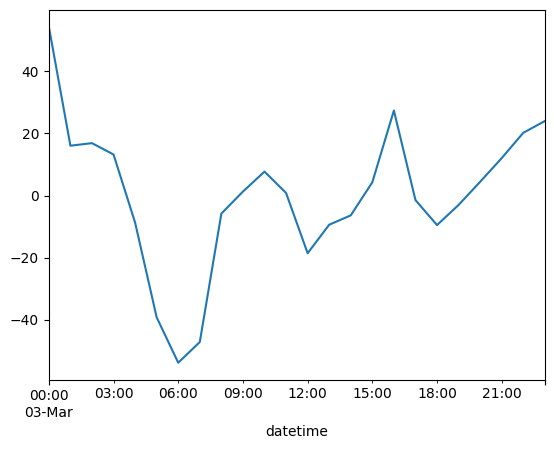

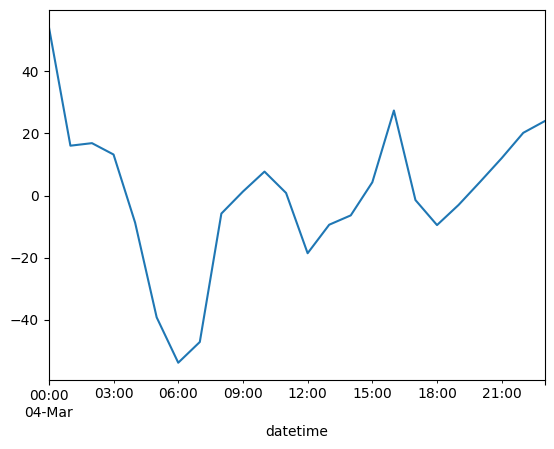

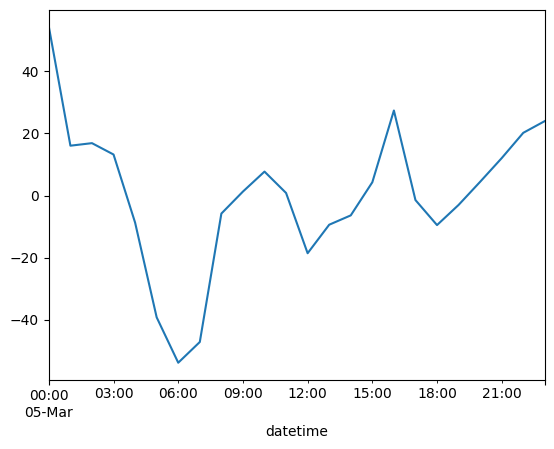

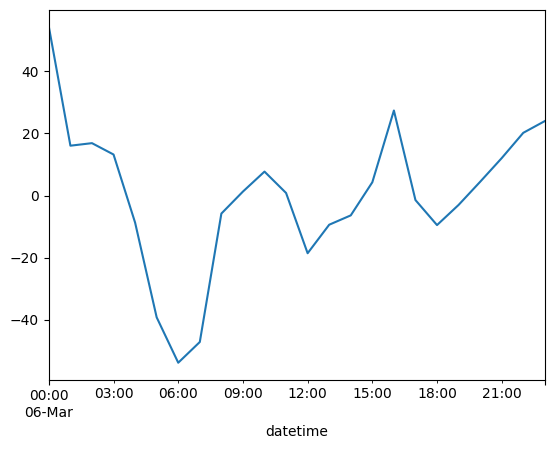

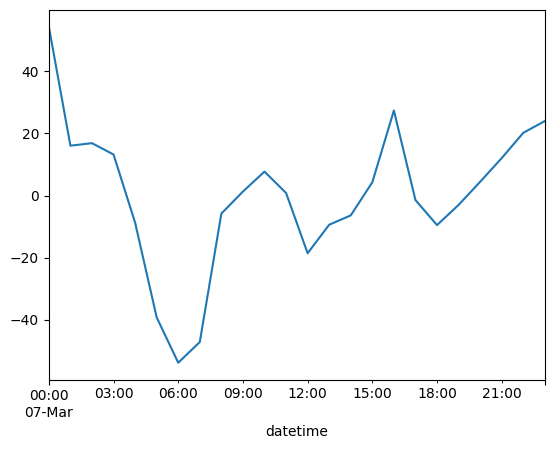

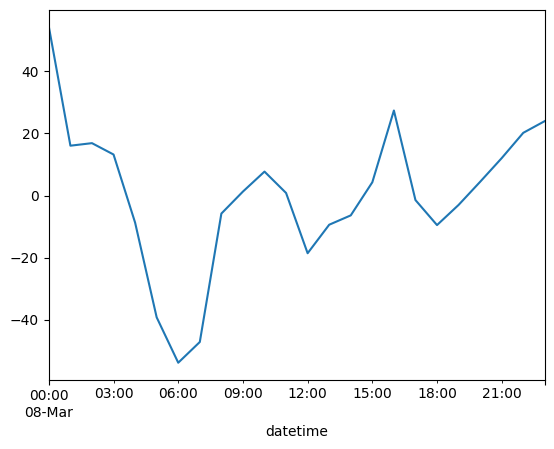

In [11]:

for i in range (8):
    i=i+1
    date='2018-03-0{}'.format(i)
    decomposed.seasonal[date].plot()
    plt.show()


- Podemos observar que en la primera semana del mes de marzo la hora con mayor pedidos de taxi es a las 00:00 horas, y el horario con menor cantidad de pedidos es a las 6:00.

## Formación

- Realizamos una funcion para crear nuevas caracteristicas para nuestro modelo

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = (data['num_orders'].shift().rolling(rolling_mean_size).mean())

- Ejecutamos nuestra funcion y mostramos las primeras filas del DataFrame obtenido.

In [13]:
make_features(df, 4, 4)
print(df.head())

                     num_orders  year  month  day  dayofweek  lag_1  lag_2  \
datetime                                                                     
2018-03-01 00:00:00         124  2018      3    1          3    NaN    NaN   
2018-03-01 01:00:00          85  2018      3    1          3  124.0    NaN   
2018-03-01 02:00:00          71  2018      3    1          3   85.0  124.0   
2018-03-01 03:00:00          66  2018      3    1          3   71.0   85.0   
2018-03-01 04:00:00          43  2018      3    1          3   66.0   71.0   

                     lag_3  lag_4  rolling_mean  
datetime                                         
2018-03-01 00:00:00    NaN    NaN           NaN  
2018-03-01 01:00:00    NaN    NaN           NaN  
2018-03-01 02:00:00    NaN    NaN           NaN  
2018-03-01 03:00:00  124.0    NaN           NaN  
2018-03-01 04:00:00   85.0  124.0          86.5  


- Creamos los conjuntos de entrenamiento y test para nuestro modelo, recordar que el proyecto nos solicita que la muestra de prueba debe ser el 10% del conjunto de datos inicial. 

In [14]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

In [15]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 04:00:00 2018-06-18 18:00:00
2018-06-18 19:00:00 2018-06-30 23:00:00


In [16]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

- Creamos nuestro modelo, lo entrenamos con los conjuntos previamente creados y declaramos nuestras variables de predicion para obtener el RECM del modelo.

In [17]:
model = LinearRegression()
model.fit(features_train, target_train)

pred_train = model.predict(features_train)
pred_test = model.predict(features_test)

## Prueba

- Mostramos el RECM del modelo con los conjuntos de entrenamiento y test.

In [18]:
print('RECM para el conjunto de entrenamiento:', mean_squared_error(target_train, pred_train)**0.5)
print('RECM para el conjunto de prueba:', mean_squared_error(target_test, pred_test)**0.5)

RECM para el conjunto de entrenamiento: 27.750895155012707
RECM para el conjunto de prueba: 30.54643364988421


## Conclusion

Sabemos que la compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico y necesitamos predecir la cantidad de pedidos de taxis para la próxima hora.

Por aagrupamos los datos por la suma total de pedidos obtenido a cada hora y graficamos la tendencia permitiendo visualizar que la hora con menos pedidos de taxi es a las 6:00  y la hora con mayor pedido es a las 00:00 horas,

Tener en cuenta que las otras horas del dia se obtienen suma de pedidos muy superiores a las 6:00 horas y estan por debajo de las 00:00 horas pero por muy poco.

Nuestro modelo obtuvo los siguientes valores de RECM con los conjuntos de entrenamiento y test.

- RECM para el conjunto de entrenamiento: 27.750895155012707
- RECM para el conjunto de prueba: 30.54643364988421

No superan los